## CS5284 Graph Machine Learning
## Sem 1 2024
### Lecturer: Xavier Bresson
### TAs: Liu Nian, Fu Guoji, Wang Jiaming

## Midterm coding test
Date: October 2nd, 2024<br> 
Time: 7pm-8pm (60min)<br>

*Instructions* <br>
Name: Please, add your name here : e.g. JOHN SMITH<br>
Answers: Please write your answers directly in this notebook by completing the code sections marked with `# YOUR CODE STARTS HERE` and `# YOUR CODE ENDS HERE`. <br>
Grading: 1 point for each question.<br>
Remark: If certain conditions of the questions (for eg. hyperparameter values) are not stated, you are free to choose anything you want.<br>


# Exercise 1 : Graph Clustering with World Happiness Dataset

## Import libraries and utility functions

In [1]:
%reset -f
import datetime
print('Timestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.sparse
from collections import defaultdict
from scipy import stats
import pandas as pd
import sklearn.metrics.pairwise
import networkx as nx
import plotly.graph_objects as go
import sys; sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
from lib.utils import interactive_vis_graph
from lib.utils import print_neighboring_countries
from lib.utils import get_same_label_countries


Timestamp: 24-10-02--18-59-30


## Load and visualize the dataset

In [7]:
wh = pd.read_csv("datasets/2019.csv") # load the dataset
# Features GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices, Generosity, Perceptions of corruption
data = wh.iloc[:,3:].to_numpy()
print('Number of data points is', data.shape[0], 'and the number of features is', data.shape[1])
print('\nFirst three data points:\n', str(data[:3]))
print('\nData statistics:')
wh.describe()


Number of data points is 156 and the number of features is 6

First three data points:
 [[1.34  1.587 0.986 0.596 0.153 0.393]
 [1.383 1.573 0.996 0.592 0.252 0.41 ]
 [1.488 1.582 1.028 0.603 0.271 0.341]]

Data statistics:


,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,5.407096,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,45.177428,1.113120,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.750000,4.544500,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,78.500000,5.379500,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,117.250000,6.184500,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,156.000000,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


## Question 1 : Data normalization

Normalize the dataset `data` so that it has a mean of zero and a standard deviation of one along each data dimension.

After normalization, print both the mean and standard deviation of the normalized dataset.

Hint: You can use the functions `numpy.mean()` and `numpy.std()` for this task.


In [23]:
##############################
# Normalize the matrix data with zero mean and unit standard deviation
# YOUR CODE STARTS HERE (it can span one or multiple lines)
data = data/ np.sqrt(np.sum(data**2,axis=0)+1e-10)
# YOUR CODE ENDS HERE
##############################


## Question 2: Construct a k-nearest neighbors (kNN) graph

Follow the instructions below to construct a k-nearest neighbors (kNN) graph from the given dataset.


In [24]:
def construct_knn_graph(M, k):
    """Construct a graph using KNN
    Args:
        M: Data matrix as ndarray of size [n, d], n being the number of data points, d the number of features
        k: the number of nearest neighbors
    Return:
        A: Adjacency graph as scipy.sparse matrix of size [n, n]
    """

    # `dist_mat` is a n x n matrix with the pairwise distance between the data points
    dist_mat = sklearn.metrics.pairwise.pairwise_distances(M, metric='euclidean', n_jobs=1)
    dist_sorted = dist_mat.copy()
    ##############################
    # Instruction: Compute the n x k `dist_sorted` matrix, where each row contains the top k smallest distances for each data point.
    #              You may use function `numpy.sort()`.
    # YOUR CODE STARTS HERE (it can span one or multiple lines)
    D=dist_sorted.copy()
    idx = np.argsort(D)[:,:k]
    Dnot_sorted = np.copy(D)
    D.sort()
    Dsorted = np.copy(D)
    print(D.shape)
    D = D[:,:k]
    dist_sorted = D.copy()
    # YOUR CODE ENDS HERE
    ##############################

    # Adjacency matrix values `adj_val`
    sigma2 = np.mean(dist_sorted[:,-1])**2 # graph scale
    adj_val = np.exp(- dist_sorted**2 / sigma2)

    # Compute the n x n sparse adjacency matrix `A`
    n = M.shape[0]
    ##############################
    # Instruction: Compute the row and column indices, `row_idx` and `col_idx`, for each edge in the adjacency matrix.
    #              You may use functions `numpy.arange()` and `numpy.argsort()` and `numpy.reshape()`.
    # YOUR CODE STARTS HERE (it can span one or multiple lines)
    row_idx = np.arange(0, n).repeat(k)
    col_idx = dist_sorted.reshape(n*k)
    # YOUR CODE ENDS HERE
    ##############################
    data = adj_val.reshape(n*k)
    A = scipy.sparse.csr_matrix((data, (row_idx, col_idx)), shape=(n, n))

    # Make A symmetric
    bigger = A.T > A
    A = A - A.multiply(bigger) + A.T.multiply(bigger)

    return A
    

(156, 156)


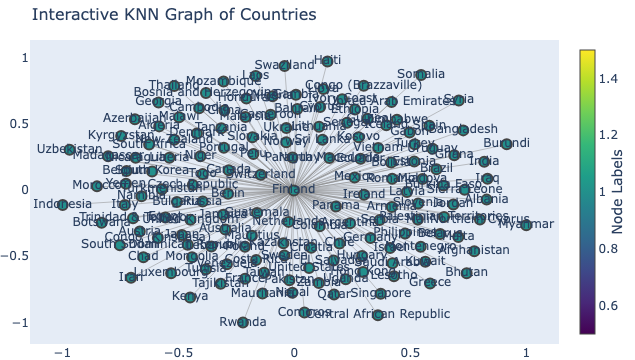

Neighboring countries of Finland:
- Denmark
- Norway
- Iceland
- Netherlands
- Switzerland
- Sweden
- New Zealand
- Canada
- Austria
- Australia
- Costa Rica
- Israel
- Luxembourg
- United Kingdom
- Ireland
- Germany
- Belgium
- United States
- Czech Republic
- United Arab Emirates
- Malta
- Mexico
- France
- Taiwan
- Chile
- Guatemala
- Saudi Arabia
- Qatar
- Spain
- Panama
- Brazil
- Uruguay
- Singapore
- El Salvador
- Italy
- Bahrain
- Slovakia
- Trinidad & Tobago
- Poland
- Uzbekistan
- Lithuania
- Colombia
- Slovenia
- Nicaragua
- Kosovo
- Argentina
- Romania
- Cyprus
- Ecuador
- Kuwait
- Thailand
- Latvia
- South Korea
- Estonia
- Jamaica
- Mauritius
- Japan
- Honduras
- Kazakhstan
- Bolivia
- Hungary
- Paraguay
- Northern Cyprus
- Peru
- Portugal
- Pakistan
- Russia
- Philippines
- Serbia
- Moldova
- Libya
- Montenegro
- Tajikistan
- Croatia
- Hong Kong
- Dominican Republic
- Bosnia and Herzegovina
- Turkey
- Malaysia
- Belarus
- Greece
- Mongolia
- North Macedonia
- Nigeria
- K

In [25]:
# Construct the graph
A = construct_knn_graph(data, k=3)

# Visualize the graph of countries 
countries = wh.iloc[:,1].values
labels = dict(zip(range(data.shape[0]), countries))
G_nx = nx.from_scipy_sparse_array(A)
G_nx.remove_edges_from(nx.selfloop_edges(G_nx)) # Remove self-loops
interactive_vis_graph(G_nx, countries, np.ones(data.shape[0]))
print_neighboring_countries(G_nx, countries, 'Finland')
print_neighboring_countries(G_nx, countries, 'Thailand')
print_neighboring_countries(G_nx, countries, 'Singapore')


## Question 3: Compute and visualize clusters of similar countries according to the features

Identify at least three countries that belong to the same cluster as Singapore.

Hint: Use the `get_same_label_countries(countries, C, 'Singapore')` function to display the countries in the same cluster as Singapore.


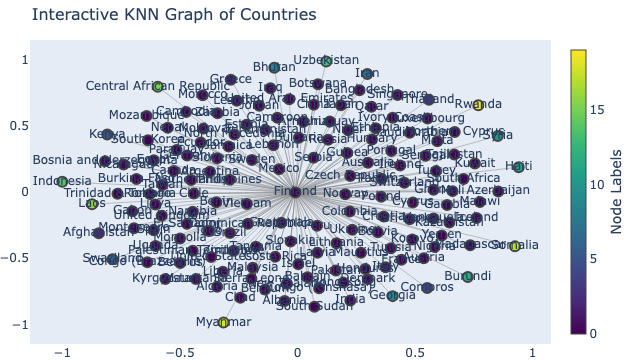

Countries in the same cluster as Singapore: ['Finland', 'Denmark', 'Norway', 'Iceland', 'Netherlands', 'Switzerland', 'Sweden', 'New Zealand', 'Canada', 'Austria', 'Australia', 'Costa Rica', 'Israel', 'Luxembourg', 'United Kingdom', 'Ireland', 'Germany', 'Belgium', 'United States', 'Czech Republic', 'United Arab Emirates', 'Malta', 'Mexico', 'France', 'Taiwan', 'Chile', 'Guatemala', 'Saudi Arabia', 'Qatar', 'Spain', 'Panama', 'Brazil', 'Uruguay', 'El Salvador', 'Italy', 'Bahrain', 'Slovakia', 'Trinidad & Tobago', 'Poland', 'Lithuania', 'Colombia', 'Slovenia', 'Nicaragua', 'Kosovo', 'Argentina', 'Romania', 'Cyprus', 'Ecuador', 'Kuwait', 'Latvia', 'South Korea', 'Estonia', 'Jamaica', 'Mauritius', 'Japan', 'Honduras', 'Kazakhstan', 'Bolivia', 'Hungary', 'Paraguay', 'Northern Cyprus', 'Peru', 'Portugal', 'Pakistan', 'Russia', 'Philippines', 'Serbia', 'Moldova', 'Libya', 'Montenegro', 'Tajikistan', 'Croatia', 'Hong Kong', 'Dominican Republic', 'Bosnia and Herzegovina', 'Turkey', 'Malaysia',

In [33]:
C, _ = compute_ncut(A, np.ones(data.shape[0]), 20)
interactive_vis_graph(G_nx, countries, C)
##############################
# YOUR CODE STARTS HERE (it can span one or multiple lines)
get_same_label_countries(countries, C, 'Singapore')
# YOUR CODE ENDS HERE
##############################
# get_same_label_countries(countries, C, 'Thailand')

print('\nTimestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))


# Exercise 2 : Graph SVM

## Import libraries and utility functions

In [38]:
%reset -f
import datetime
print('Timestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))

import numpy as np
import scipy.io
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_purity
from lib.utils import compute_SVM
from lib.utils import construct_knn_graph
import warnings; warnings.filterwarnings("ignore")
import sklearn.metrics.pairwise


Timestamp: 24-10-02--19-39-27


## Load and visualize the dataset

Number of data points is 500 , the number of features is 2 and the number of clusters is 2
number of labeled data per class: 1
number of unlabeled data: 498


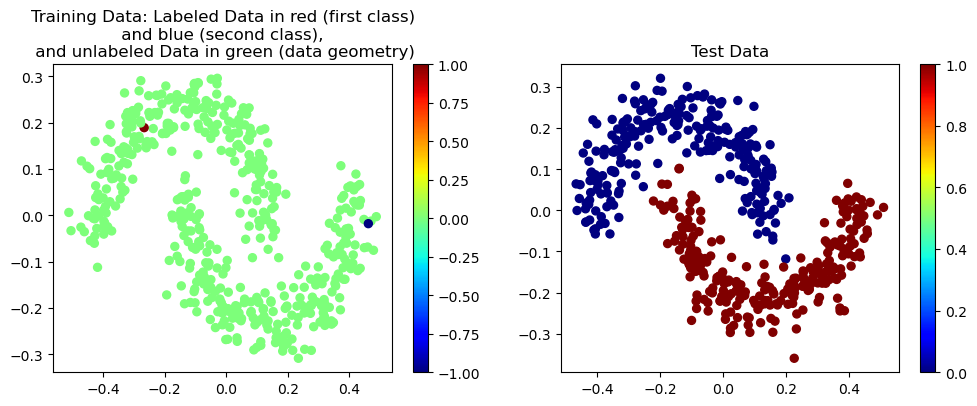

In [39]:
# Dataset
mat = scipy.io.loadmat('datasets/data_twomoons_graphSVM.mat')
Xtrain = mat['Xtrain']
Cgt_train = mat['Cgt_train'] - 1; Cgt_train = Cgt_train.squeeze()
l_train = mat['l'].squeeze()
nb_labeled_data_per_class = mat['nb_labeled_data_per_class'].squeeze()
n = Xtrain.shape[0]
d = Xtrain.shape[1]
nc = len(np.unique(Cgt_train))
print('Number of data points is', n, ', the number of features is', d, 'and the number of clusters is', nc)
Xtest = mat['Xtest']
Cgt_test = mat['Cgt_test'] - 1; Cgt_test = Cgt_test.squeeze()
#print('l_train:',l_train)
print('number of labeled data per class:',nb_labeled_data_per_class)
print('number of unlabeled data:',n-2*nb_labeled_data_per_class)

# Plot
plt.figure(figsize=(12,4))
p1 = plt.subplot(121)
size_vertex_plot = 33
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=size_vertex_plot*np.ones(n), c=l_train, color=pyplot.jet())
plt.title('Training Data: Labeled Data in red (first class)\n and blue (second class), \n and unlabeled Data in green (data geometry)')
plt.colorbar()
p2 = plt.subplot(122)
size_vertex_plot = 33
plt.scatter(Xtest[:,0], Xtest[:,1], s=size_vertex_plot*np.ones(n), c=Cgt_test, color=pyplot.jet())
plt.title('Test Data')
plt.colorbar()
#plt.tight_layout()
plt.show()


## Question 1: Compute the Laplacian Kernels

The n x n Laplacian Kernel matrix is defined as
  
$$K_{ij} = \exp\left(-\frac{\|x_i - x_j\|_1}{\sigma}\right), \textrm{ where $\| \cdot \|_1$ denotes the L1 norm or Manhattan distance}$$

Follow the instructions below to construct the Laplacian Kernels from the given dataset.


In [41]:
# Compute Laplacian kernel
sigma = 0.5  # Kernel scale

##############################
# Instructions: 
# Let n be the number of training data points and n_test be the number of test data points.
# 1) Compute the n x n pairwise L1 distance matrix `l1_dists_train` using the training matrix `Xtrain`.
# 2) Compute the n x n_test pairwise L1 distance matrix `l1_dists_test` between the training matrix `Xtrain` and the test matrix `Xtest`.
# 3) Compute the n x n Laplacian kernel matrix `Ker` for the training set.
# 4) Compute the n x n_test Laplacian kernel matrix `KXtest` between the training set and the test set.
# Hint : You may use function `sklearn.metrics.pairwise.manhattan_distances()` to compute the 
#        pairwise distance between data points with the L1 norm.
# YOUR CODE STARTS HERE (it can span one or multiple lines)
l1_dists_train = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtrain, metric='manhattan', n_jobs=1)
l1_dists_test = sklearn.metrics.pairwise.pairwise_distances(Xtrain, Xtest, metric='manhattan', n_jobs=1)
Ker = np.exp(- l1_dists_train / sigma)
KXtest = np.exp(- l1_dists_test / sigma)
# YOUR CODE ENDS HERE
##############################


## Question 2: Compute the k-nearest neighbors graph and its Laplacian

The n x n kNN graph matrix defined as

$$ 
A_{ij} = 
\left\{
\begin{array}{ll}
e^{-\frac{\textrm{dist}(x_i,x_j)^2}{\sigma^2}} & \textrm{ if } j\in\mathcal{N}^k_i\\
0 & \textrm{otherwise} \\
\end{array}
\right. , \
\textrm{ where $\textrm{dist}(\cdot,\cdot)$ is the cosine distance.} 
$$

Follow the instructions below to construct the kNN graph and the n x n unnormalized Laplacian matrix
$$ 
L = D - A, \
\textrm{ where $D$ is n x n diagonal degree matrix.} 
$$
  

In [50]:
# Compute mutual kNN graph
kNN = 10

##############################
# Instructions: 
# 1) Compute the n x n k-nearest neighbors (kNN) graph adjacency matrix `A` from the training set `Xtrain`.
# 2) Compute the n x n diagonal degree matrix `D`.
# 3) Compute the n x n unnormalized Laplacian matrix `L`.
# Hint: You may use the function `construct_knn_graph(X, kNN, 'cosine')` to compute the kNN graph matrix `A` using cosine similarity.
# YOUR CODE STARTS HERE (it can span one or multiple lines)
row = Xtrain[:,0]
col = Xtrain[:,1]
nv = Xtrain.shape[0]
data = np.ones([nv])
A = scipy.sparse.csr_matrix((data, (row, col)), shape=(nv, nv))
A = A.toarray()
D = scipy.sparse.diags(d.A.squeeze(), 0)
L = D-A
# YOUR CODE ENDS HERE
##############################


AttributeError: 'int' object has no attribute 'A'

## Question 3: Implement a semi-supervised classification technique using manifold regularization

The optimization problem is formulated as follows :
  
$$
\min_{f:V\rightarrow\mathbb{R}} \ \sum_{i \in Y_l} (f_i - y_i)^2 + \lambda_G \sum_{i,j\in V} A_{ij} (f_i - f_j)^2, \\
$$ 
or equivalently,
$$
\min_{f:V\rightarrow\mathbb{R}} \ \sum_{i \in V} \textrm{Ind}_{ii}(f_i - y_i)^2 + \lambda_G \sum_{i,j\in V} A_{ij} (f_i - f_j)^2, \quad (1) \\
$$
where:
- $Y_l$ is the set of indices of labeled data,
- $y_i$ is the label value for $i \in Y_l$,
- $V$ is the set of all data points,
- $\textrm{Ind}_{ii}$ is the diagonal indicator matrix with $\textrm{Ind}_{ii}=1$ if $i$ is a labeled data point and $0$ otherwise, and
- $\lambda_G>0$ is the graph regularization parameter.

Energy (1) can be re-written in matrix-vector notation as follows :
$$
\min_{f\in\mathbb{R}^n} \|\textrm{Ind}(f-y)\|^2_2 + \lambda_G f^TLf, \ y\in\mathbb{R}^n, \ \textrm{Ind}\in\mathbb{R}^{n\times n}  \quad (2) \\
$$
where $L\in\mathbb{R}^{n\times n}$ is the unnormalized Laplacian.

To solve (2), you need to address the linear system of equations of the form $Af = b$ with:
- $A=\textrm{Ind}+\lambda_G L\in\mathbb{R}^{n\times n}$
- $b=\textrm{Ind}\ y\in\mathbb{R}^{n}$
  
Your task is to compute the solution f of this linear system numerically.

Hint: You may use functions `numpy.diag()`, `nump.matmul()`, and `f = numpy.linalg.solve(A,b)`.


In [ ]:
# Compute semi-supervised classification function

lambda_G = 1.0
labeled_indices = np.where(np.abs(l_train) > 0)[0]
y = np.zeros([n]); y[labeled_indices] = l_train[labeled_indices]

##############################
# Instructions: 
# 1) Compute the indicator matrix Ind.
# 2) Construct the matrix A = Ind + lambda_G . L
# 3) Calculate the vector b = Ind * y
# 4) Find the solution f by solving the linear system : f = A^{-1} * b 
# YOUR CODE STARTS HERE (it can span one or multiple lines)
Ind = 
A = 
b = 
f = 
# YOUR CODE ENDS HERE
##############################


## Question 4: Evaluate the model on the test set

Assign labels based on the sign of $f$.

Compute the accuracy on both the training and test datasets. You must have `accuracy_test > 0.70`.

Visualize the classification boundaries using spectral features.


In [ ]:
# Assign labels
##############################
# YOUR CODE STARTS HERE (it can span one or multiple lines)
C_pred_train = 
# YOUR CODE ENDS HERE
##############################
C_pred_test = (KXtest.T @ f > 0).astype(int)

# Compute accuracy
accuracy_train = compute_purity(C_pred_train, Cgt_train, nc)
accuracy_test = compute_purity(C_pred_test, Cgt_test, nc)

print('Training accuracy:', accuracy_train)
print('Test accuracy:', accuracy_test)

# Visualization
eigvals, eigvecs = scipy.linalg.eigh(L, D, subset_by_index=[0,2])
plt.figure(figsize=(8, 6))
plt.scatter(eigvecs[:, 1], eigvecs[:, 2], c=C_pred_train, cmap='viridis', s=50)
plt.title('Spectral Clustering with semi-supervised classification')
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.colorbar()
plt.show()

print('\nTimestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))


# Exercise 3 : Recommendation on Graphs


## Import libraries and utility functions


In [36]:
%reset -f
import datetime
print('Timestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))

import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")
from lib.utils import compute_ncut, reindex_W_with_classes, construct_knn_graph
import torch
import networkx as nx


Timestamp: 24-10-02--19-31-35


IOStream.flush timed out


## Question 1: Compute the Personalized PageRank (PPR) operator

The PPR solution is the steady-state vector $u^\infty \in \mathbb{R}^n$ of the iterative update :
$$
u^{k+1} = αD^{-1}A^Tu^k+(1-\alpha)\frac{1_n}{n}\in\mathbb{R}^n, \ \textrm{for $k\rightarrow\infty$}.
$$

At convergence, the solution can be written as:
$$
u^\infty = \text{O}_\text{PPR} b \in \mathbb{R}^n,
$$
where
- $\text{O}_\text{PPR} = (1-\alpha)(I - αD^{-1}A^T)^{-1} \in\mathbb{R}^{n\times n}$ is the Personalized PageRank operator.
- $b = \frac{1_n}{n}\in\mathbb{R}^n$ is the uniform distribution across the network nodes.

Follow the instructions below to implement the n x n Personalized PageRank operator $\text{O}_\text{PPR}$.


In [ ]:
def compute_PPR_operator(A, alpha=0.85):
    # Inputs :
    #  A is the n x n adjacency matrix with numpy type
    #  alpha is the smoothing parameter with standard value alpha=0.85
    # Output :
    #  O_PPR is the n x n PPR operator matrix
    ##############################
    # Instructions: 
    # 1) Compute the degree matrix D.
    # 2) Construct the Personalized PageRank matrix O_PPR = (1 - alpha) * (I - alpha * D^{-1} * A^T)^{-1).
    # Hint: You may use functions `numpy.diag()`, `numpy.eye()` and `numpy.linalg.inv()`.
    # YOUR CODE STARTS HERE (it can span one or multiple lines)
    D = 
    O_PPR = 
    # YOUR CODE ENDS HERE
    ##############################
    O_PPR = np.real(O_PPR) # retain real part of complex eigenvectors 
    O_PPR[O_PPR < 1e-2] = 0 # remove small values
    return O_PPR
    

## Question 2: Compute the Heat Kernel PageRank (HKPR) operator

The Personalized PageRank operator from the previous question defines a diffusion process on the graph. An alternative diffusion method is the Heat Kernel PageRank, which is defined as:
$$
u(t)=\sum_{k=0}^\infty \exp(-t)\frac{t^k P^k}{k!}b\in\mathbb{R}^n, \ \textrm{ where $P=D^{-1}A^T$ and $b=\frac{1_n}{n}\in\mathbb{R}^n$}
$$

Here, $t>0$ is a time parameter that controls the extent of the diffusion process. A larger $t$ value allows for more extensive diffusion.

First, compute analytically the Heat Kernel PageRank operator:
$$
\text{O}_\text{HKPR} = \sum_{k=0}^\infty \exp(-t)\frac{t^k P^k}{k!} \in\mathbb{R}^{n\times n}\quad (1)
$$
Hint: Use the Taylor expansion of $\exp(x)$, which is $\sum_{n=0}^\infty\frac{x^n}{n!}$.

Second, follow the instructions below to implement the n x n Heat Kernel PageRank operator $\text{O}_\text{HKPR}$.

Hint: For a matrix $M$ that holds an Eigenvalue Decomposition (EVD), $M=UΛU^{-1}$, and for any elementary function like $f(x)=\exp(x)$, we have $f(M)=Uf(Λ)U^{-1}$.


In [ ]:
def compute_HKPR_operator(A, t=0.5):
    # Inputs :
    #  A is the n x n adjacency matrix with numpy type
    #  t is the time parameter
    # Output :
    #  O_HKPR is the n x n HKPR operator matrix
    ##############################
    # Instructions : 
    # 1) Compute the degree matrix D.
    # 2) Construct the matrix O_HKPR by implementing the analytical solution of Eq. (1).
    # Hint: You may use functions `numpy.linalg.eig()`, `numpy.exp()`, `numpy.linalg.pinv()`.
    # YOUR CODE STARTS HERE (it can span one or multiple lines)
    D = 
    O_HKPR = 
    # YOUR CODE ENDS HERE
    ##############################
    O_HKPR = np.real(O_HKPR) # retain real part of complex eigenvectors 
    O_HKPR[O_HKPR < 1e-2] = 0 # remove small values
    return O_HKPR
    

## Question 3: Compute the recommender system using Personalized and Heat Kernel PageRank operators

The operators $\text{O}_\text{PPR}$ and $\text{O}_\text{HKPR}$ measure the influence between pairs of nodes within the graph, much like the adjacency matrix $A$. 

However, $\text{O}_\text{PPR}$ and $\text{O}_\text{HKPR}$ capture more nuanced and smoother relationships between nodes compared to $A$. This makes them potentially better suited for recommendation tasks, where capturing deeper connections can enhance performance.

In this question, we will replace the adjacency matrix $A$ with both $\text{O}_\text{PPR}$ and $\text{O}_\text{HKPR}$ and evaluate whether they improve the recommender system's accuracy.

Follow the instructions below to implement the recommender system solutions using the Personalized PageRank and Heat Kernel PageRank operators, and compare the results with the standard system that uses the adjacency matrix $A$.


In [ ]:
# Load graphs of rows/users and columns/products
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario2.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']

print('M', M.shape)
print('Otraining', Otraining.shape)
print('Otest', Otest.shape)
print('Wrow', Wrow.shape)
print('Wcol', Wcol.shape)

n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining)/(n*m)
print('perc_obs_training=',perc_obs_training)
perc_obs_test = np.sum(Otest) / (n*m)
print('perc_obs_test=',perc_obs_test)

# visualize ratings
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])
plt.colorbar(shrink=0.65)
plt.subplot(1,2,2)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.colorbar(shrink=0.65)
plt.tight_layout()
plt.show()

# plot graph of users
nc = 10; Cncut_row, _ = compute_ncut(Wrow, np.zeros(Mgt.shape[0]), nc)# compute NCut clustering
[reindexed_W_row_ncut,reindexed_C_row_ncut] = reindex_W_with_classes(Wrow, Cncut_row)
A_row = Wrow.copy()
A_row.setdiag(0)
A_row.eliminate_zeros()
G_nx_row = nx.from_scipy_sparse_array(A_row)

# plot graph of items
nc = 10; Cncut_col, _ = compute_ncut(Wcol, np.zeros(Mgt.shape[1]), nc)# compute NCut clustering
[reindexed_W_col_ncut,reindexed_C_col_ncut] = reindex_W_with_classes(Wcol, Cncut_col)
A_col = Wcol.copy()
A_col.setdiag(0)
A_col.eliminate_zeros()
G_nx_col = nx.from_scipy_sparse_array(A_col)

# visualize graphs
plt.figure(figsize=(24, 6))
plt.subplot(1,4,1)
plt.spy(reindexed_W_row_ncut, precision=0.01, markersize=1)
plt.title('Adjacency matrix of users indexed \naccording to the NCut communities')
plt.subplot(1,4,2)
nx.draw_networkx(G_nx_row, with_labels=False, node_color=np.array(Cncut_row), cmap='jet', node_size = 50)
plt.title('Network visulization of users')
plt.subplot(1,4,3)
plt.spy(reindexed_W_col_ncut, precision=0.01, markersize=1)
plt.title('Adjacency matrix of products indexed \naccording to the NCut communities)')
plt.subplot(1,4,4)
nx.draw_networkx(G_nx_col, with_labels=False, node_color=np.array(Cncut_col), cmap='jet', node_size = 50)
plt.title('Network visulization of products')
plt.tight_layout()
plt.show()


In [ ]:
# Compute O_PPR and O_HKPR from both row/user graph and column/product graph
O_PPR_row = compute_PPR_operator(Wrow.todense())
O_HKPR_row = compute_HKPR_operator(Wrow.todense())
O_PPR_col = compute_PPR_operator(Wcol.todense())
O_HKPR_col = compute_HKPR_operator(Wcol.todense())

def symmetrize(A):
    bigger = A.T > A
    A = A - A.multiply(bigger) + A.T.multiply(bigger)
    return A
    
# Convert to scipy.sparse matrix and symmetrize the matrix
O_PPR_row = symmetrize(scipy.sparse.csc_matrix(O_PPR_row))
O_PPR_col = symmetrize(scipy.sparse.csc_matrix(O_PPR_col))
O_HKPR_row = symmetrize(scipy.sparse.csc_matrix(O_HKPR_row))
O_HKPR_col = symmetrize(scipy.sparse.csc_matrix(O_HKPR_col))

def graph_laplacian(W):
        d = W.sum(axis=0)
        d = 1.0 / np.sqrt(d)
        D = scipy.sparse.csc_matrix(np.diag(d.A[0]))
        I = scipy.sparse.identity(d.size)
        L = I - D * W * D
        return L

def compute_Lr_Lc(Wrow, Wcol): # Wrow: row/user operator, Wcol: column/product operator
    Lr = graph_laplacian(Wrow)
    Lc = graph_laplacian(Wcol)
    ##############################
    # The linear system of equations for least-squares optimization with graph regularization can be expressed as:
    #  $(I_m ⊗ L_r + L_c ⊗ I_n + λ O_{mn}) = λ m$, where $⊗$ denotes the Kronecker product.
    # Instructions: 
    # Given the Laplacian operators L_r and L_c for the rows and columns of the matrix,
    # compute the terms `ILr` = I_m ⊗ L_r and `LcI` = L_c ⊗ I_n.
    # Hint: You may use functions `scipy.sparse.identity()`, `scipy.sparse.kron()`.
    # YOUR CODE STARTS HERE (it can span one or multiple lines)
    ILr = 
    LcI = 
    # YOUR CODE ENDS HERE
    ##############################
    ILr = scipy.sparse.csr_matrix(ILr)
    LcI = scipy.sparse.csr_matrix(LcI)
    return ILr, LcI


lambdaDir = 1e-1 * 1e0; lambdaDF = 1e1; alpha = 0.02

def content_recommendation(Wrow, Wcol):

    # Compute I_m ⊗ L_r and L_c ⊗ I_n
    ILr, LcI = compute_Lr_Lc(Wrow, Wcol)
    
    # Pre-processing
    L = alpha* LcI + (1.-alpha)* ILr
    vecO = np.reshape(O.T,[-1])
    vecO = scipy.sparse.diags(vecO, 0, shape=(n*m, n*m) ,dtype=L.dtype)
    vecO = scipy.sparse.csr_matrix(vecO)
    At = lambdaDir* L + lambdaDF* vecO
    vecM = np.reshape(M.T,[-1])
    bt = lambdaDF* scipy.sparse.csr_matrix( vecM ).T
    bt = np.array(bt.todense()).squeeze()

    # Solve the linear system
    x,_ = scipy.sparse.linalg.cg(At, bt, x0=bt, tol=1e-9, maxiter=100)
    X = np.reshape(x,[m,n]).T

    # Compute reconstruction error
    err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)
    return err_test

    
standard_err_test = content_recommendation(Wrow, Wcol)
ppr_err_test = content_recommendation(O_PPR_row, O_PPR_col)
hkpr_err_test = content_recommendation(O_HKPR_row, O_HKPR_col)

print("Reconstuction Error on Test")
print("Adjacency matrix (standard): ", standard_err_test)
print("Personalized PageRank operator: ", ppr_err_test)
print("Heat Kernel PageRank operator: ", hkpr_err_test)

print('\nTimestamp:',datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S"))


## Question 4: Evaluate the following statements regarding the advantages of the Heat Kernel PageRank (HKPR) operator over the Personalized PageRank (PPR) operator. Select all responses that apply (you may choose 0, 1, or multiple responses).

A. The time parameter $t$ in HKPR is small, while the parameter $\alpha$ in PPR is larger.\
B. The flexibility of the time parameter $t$ in HKPR allows for improved control over which local vs. global structure to prioritize.\
C. HKPR offers a smooth transition of influence between nodes, whereas PPR can result in abrupt changes.  


**Answer**: 